 **SIAMESE NETWORK WITH CONTRASTIVE LOSS**

In [4]:
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
import os
import cv2
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [6]:
#must put the notebook setting on GPU first
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import sys 
from google.colab import drive 
import glob

path = "/content/drive" 
drive.mount(path, force_remount=True)  
data_path = "drive/MyDrive/AML_Challenge/dataset_senza_aug" 

myfiles = glob.glob(os.path.join(data_path, '*')) 
print(myfiles)

Mounted at /content/drive
['drive/MyDrive/AML_Challenge/dataset_senza_aug/training', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/test']


In [7]:
class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.endswith('.jpg'):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                        self.data_mapping[img_tmp] = int(c_name)

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()),
                                                    self.data_path))

    def get_data_paths(self):
        # returns a list of images paths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.endswith('.jpg'):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)


    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)




# dataset folder has inside two folders: training and validation
# the validation one contains the query and gallery folders

validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(validation_path, 'gallery')
query_path = os.path.join(validation_path, 'query')
training_path = os.path.join(data_path, "training") 

training_dataset = Dataset(data_path = training_path)
gallery_dataset = Dataset(data_path=gallery_path)
query_dataset = Dataset(data_path=query_path)

# get training data and classes
training_paths, training_classes = training_dataset.get_data_paths()

# get validation gallery and query data
gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()


Loaded 697 from drive/MyDrive/AML_Challenge/dataset_senza_aug/training images
Loaded 534 from drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery images
Loaded 70 from drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/query images


In [8]:
def euclidean_distance(vectors):
  '''
  Unpack the input into two lists, one for the first features one for the second;
  compute the sum of squared distances between the features and return the euclidean distance.
  '''
  (featuresA, featuresB) = vectors
  sum_squared = K.sum(K.square(featuresA - featuresB), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [9]:
def plot_training(hist, plot_path):
	'''
  This function the training and validation loss over the number of epochs and saves the training history.
  '''
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(hist.history['loss'], label = 'train_loss')
	plt.plot(hist.history['val_loss'], label = 'val_loss')
	plt.title('Training Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend(loc = 'upper left')
	plt.savefig(plot_path)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications.resnet import ResNet50

def siamese_network(inputShape = (224, 224, 3)):
  base_cnn = ResNet50(weights="imagenet", input_shape=(224, 224, 3), include_top=False, pooling='max')

  flatten = Flatten()(base_cnn.output)
  dense1 = Dense(512, activation="relu")(flatten)
  dense1 = BatchNormalization()(dense1)
  dense2 = Dense(256, activation="relu")(dense1)
  dense2 = BatchNormalization()(dense2)
  outputs = Dense(256, activation='sigmoid')(dense2)
  
  model = Model(base_cnn.input, outputs)

  return model


model = siamese_network((224,224,3))
model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [11]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Lambda

def contrastive_loss(y, preds, margin=1):
  '''
  This function computes the contrastive loss between the true labels and the predicted labels and returns it.
  '''
  y = tf.cast(y, preds.dtype) 
  #cast forces the two class label of being of the same data type; 
  #specifically of the type of the predicted class (preds)
    
  squared_preds = K.square(preds)
  squared_margin = K.square(K.maximum(margin - preds, 0))
  loss = K.mean(y * squared_preds + (1 - y) * squared_margin)

  return loss

In [12]:
def process_images(imgg):
  '''
  This function preprocess the images so than they are reduced to normalized numpy arrays.
  '''
  input_shape = (224, 224, 3)
  norm_img = []
  for n in range(len(imgg)):
    img = image.load_img(imgg[n], target_size=(input_shape[0], input_shape[1]))
    
    img = img.convert('RGB') #make sure the images are in color, since some may be in balck and white in our dataset.
    x = image.img_to_array(img) #convert image to np.array (height H x width W x channel C), dtype=float32
    x = np.expand_dims(x, axis=0)  # (H, W, C) -> (1, H, W, C), where the first element is the number of images (batch size)
    x = x / np.linalg.norm(x) #normalize
    norm_img.append(x)
  return norm_img

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(training_paths, training_classes, test_size=0.3, random_state=42)

In [14]:
trainX = process_images(x_train)
testX = process_images(x_test)

In [15]:
def make_pairs(images, labels):
  '''
  This function produces pairs of images with their labels.
  Returns a tuple of two arrays, one with pairs of images and the other with label 0 if the images belong to different classes, else 1.
  '''
  
  images_pairs = []
  labels_pairs_lst = []

  number_of_classes = len(np.unique(labels)) #total number of classes present in the dataset

  #list of indexes for each label that provides the indexes for all examples within a given label
  idx = [np.where(labels == i)[0] for i in range(0, number_of_classes) if len(np.where(labels == i)[0]) > 0]

  for idxA in range(len(images)):
    current_img = images[idxA]
    label = labels[idxA] #label of the current image

    if label < len(idx):
      #pick a random image belonging to the same class as the current image (positive image)
      idxB = np.random.choice(idx[label]) 
      positive_img = images[idxB]
      #positive pair:
      images_pairs.append([current_img, positive_img])
      labels_pairs_lst.append([1])
      
      #pick a random image belonging to a different class as the current image (negative image)
      negIdx = np.where(labels != label)[0]
      negative_img = images[np.random.choice(negIdx)]
      #negative pair:
      images_pairs.append([current_img, negative_img])
      labels_pairs_lst.append([0])
  return (np.array(images_pairs), np.array(labels_pairs_lst))

In [16]:
#Computing positive and negative pairs
(pairTrain, labelTrain) = make_pairs(trainX, y_train)
(pairTest, labelTest) = make_pairs(testX, y_test)

In [17]:
pairTrain[:,0,0].shape

(424, 224, 224, 3)

In [18]:
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 4 
EPOCHS = 100

In [19]:
#configure the siamese network
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = siamese_network(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

#construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer="adam")

In [ ]:
def create_model():
    model = Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(optimizer='adam', loss=contrastive_loss)
    return model

checkpoint_dir = os.path.join(data_path, 'siamese_checkpoints')

def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + '/' + name
                   for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print('Restoring from {}'.format(latest_checkpoint))
        model = tf.keras.models.load_model(latest_checkpoint, compile=False)
        model.compile(optimizer='adam', loss=contrastive_loss, metrics=['accuracy'])
        return model
    print('No previouly saved models, creating a new one')
    return create_model()


# train the model
callbacks = [
    # This callback saves a SavedModel every 30 batches.
    # We include the training loss in the folder name.
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + '/ckpt-loss={loss:.2f}',
        save_freq=100)
]
model = make_or_restore_model()


No previouly saved models, creating a new one


In [ ]:
from keras.callbacks import EarlyStopping #Stop training when a monitored metric has stopped improving; inherit from Callback
from keras.callbacks import ReduceLROnPlateau #Reduce learning rate when a metric has stopped improving; inherit from Callback

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'auto', restore_best_weights = True) 
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.8, patience = 10, min_lr = 1e-6, cooldown = 5, verbose = 0) 


print("Training model...")
history = model.fit(
    [pairTrain[:, 0, 0], pairTrain[:, 1, 0]], labelTrain[:],
	validation_data = ([pairTest[:, 0, 0], pairTest[:, 1, 0]], labelTest[:]),
	batch_size = BATCH_SIZE,
	epochs = EPOCHS, #should stop by itself when no improvement thanks to EarlyStopping
  callbacks = [callbacks, reduce_lr, early_stopping]) #callbacks 

Training model...
Epoch 1/100
  4/106 [>.............................] - ETA: 12s - loss: 0.2831

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.28/assets
104/106 [============================>.] - ETA: 0s - loss: 0.4584

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.46/assets
106/106 [==============================] - 75s 708ms/step - loss: 0.4584 - val_loss: 0.4997
Epoch 2/100
 98/106 [==========================>...] - ETA: 0s - loss: 0.3930

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.39/assets
106/106 [==============================] - 44s 421ms/step - loss: 0.3934 - val_loss: 0.4993
Epoch 3/100
 92/106 [=========================>....] - ETA: 1s - loss: 0.3058

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 46s 433ms/step - loss: 0.3190 - val_loss: 0.4982
Epoch 4/100
 86/106 [=======================>......] - ETA: 2s - loss: 0.3446

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.34/assets
106/106 [==============================] - 45s 427ms/step - loss: 0.3338 - val_loss: 0.4905
Epoch 5/100
 80/106 [=====================>........] - ETA: 3s - loss: 0.3374

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.34/assets
106/106 [==============================] - 45s 423ms/step - loss: 0.3225 - val_loss: 0.4652
Epoch 6/100
 74/106 [===================>..........] - ETA: 3s - loss: 0.3280

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.33/assets
106/106 [==============================] - 43s 411ms/step - loss: 0.3139 - val_loss: 0.4368
Epoch 7/100
 68/106 [==================>...........] - ETA: 4s - loss: 0.2874

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 44s 416ms/step - loss: 0.3009 - val_loss: 0.4355
Epoch 8/100
 62/106 [================>.............] - ETA: 5s - loss: 0.2954

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.30/assets
106/106 [==============================] - 45s 426ms/step - loss: 0.3355 - val_loss: 0.4559
Epoch 9/100
 56/106 [==============>...............] - ETA: 6s - loss: 0.3550

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.36/assets
106/106 [==============================] - 45s 432ms/step - loss: 0.3317 - val_loss: 0.3199
Epoch 10/100
 50/106 [=============>................] - ETA: 6s - loss: 0.2854

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 44s 418ms/step - loss: 0.3023 - val_loss: 0.3064
Epoch 11/100
 44/106 [===========>..................] - ETA: 7s - loss: 0.3245

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 44s 416ms/step - loss: 0.3185 - val_loss: 0.3227
Epoch 12/100
 38/106 [=========>....................] - ETA: 8s - loss: 0.3168

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 45s 427ms/step - loss: 0.3287 - val_loss: 0.4792
Epoch 13/100
 32/106 [========>.....................] - ETA: 9s - loss: 0.3282

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.33/assets
106/106 [==============================] - 44s 421ms/step - loss: 0.3352 - val_loss: 0.4997
Epoch 14/100
 26/106 [======>.......................] - ETA: 9s - loss: 0.3413

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.34/assets
106/106 [==============================] - 43s 412ms/step - loss: 0.3218 - val_loss: 0.3686
Epoch 15/100
 20/106 [====>.........................] - ETA: 10s - loss: 0.3520

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.35/assets
106/106 [==============================] - 44s 421ms/step - loss: 0.3223 - val_loss: 0.3320
Epoch 16/100
 14/106 [==>...........................] - ETA: 10s - loss: 0.2562

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.26/assets
106/106 [==============================] - 44s 418ms/step - loss: 0.2830 - val_loss: 0.5014
Epoch 17/100
  8/106 [=>............................] - ETA: 11s - loss: 0.2748

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.27/assets
106/106 [==============================] - 44s 415ms/step - loss: 0.3094 - val_loss: 0.3315
Epoch 18/100
  2/106 [..............................] - ETA: 12s - loss: 0.3823

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.38/assets
102/106 [===========================>..] - ETA: 1s - loss: 0.3091

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 75s 716ms/step - loss: 0.3078 - val_loss: 0.3405
Epoch 19/100
 96/106 [==========================>...] - ETA: 1s - loss: 0.3072

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 45s 426ms/step - loss: 0.3091 - val_loss: 0.3280
Epoch 20/100
 90/106 [========================>.....] - ETA: 1s - loss: 0.2730

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.27/assets
106/106 [==============================] - 45s 424ms/step - loss: 0.2843 - val_loss: 0.3022
Epoch 21/100
 84/106 [======================>.......] - ETA: 2s - loss: 0.3241

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 44s 413ms/step - loss: 0.3218 - val_loss: 0.3629
Epoch 22/100
 78/106 [=====================>........] - ETA: 3s - loss: 0.2908

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 44s 415ms/step - loss: 0.2966 - val_loss: 0.3913
Epoch 23/100
 72/106 [===================>..........] - ETA: 4s - loss: 0.2750

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.28/assets
106/106 [==============================] - 45s 432ms/step - loss: 0.2944 - val_loss: 0.3772
Epoch 24/100
 66/106 [=================>............] - ETA: 4s - loss: 0.2977

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.30/assets
106/106 [==============================] - 45s 424ms/step - loss: 0.2995 - val_loss: 0.2849
Epoch 25/100
 60/106 [===============>..............] - ETA: 5s - loss: 0.3287

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.33/assets
106/106 [==============================] - 44s 415ms/step - loss: 0.3260 - val_loss: 0.3000
Epoch 26/100
 54/106 [==============>...............] - ETA: 6s - loss: 0.3031

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.30/assets
106/106 [==============================] - 45s 427ms/step - loss: 0.3220 - val_loss: 0.3975
Epoch 27/100
 48/106 [============>.................] - ETA: 6s - loss: 0.2768

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.28/assets
106/106 [==============================] - 45s 428ms/step - loss: 0.3078 - val_loss: 0.3090
Epoch 28/100
 42/106 [==========>...................] - ETA: 7s - loss: 0.3178

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 45s 424ms/step - loss: 0.3147 - val_loss: 0.3893
Epoch 29/100
 36/106 [=========>....................] - ETA: 8s - loss: 0.3602

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.36/assets
106/106 [==============================] - 45s 428ms/step - loss: 0.3298 - val_loss: 0.3481
Epoch 30/100
 30/106 [=======>......................] - ETA: 9s - loss: 0.3182

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 44s 422ms/step - loss: 0.3179 - val_loss: 0.2848
Epoch 31/100
 24/106 [=====>........................] - ETA: 9s - loss: 0.3070

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 45s 426ms/step - loss: 0.3162 - val_loss: 0.3836
Epoch 32/100
 18/106 [====>.........................] - ETA: 10s - loss: 0.3423

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.34/assets
106/106 [==============================] - 44s 416ms/step - loss: 0.3295 - val_loss: 0.3727
Epoch 33/100
 12/106 [==>...........................] - ETA: 10s - loss: 0.3372

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.34/assets
106/106 [==============================] - 44s 417ms/step - loss: 0.3110 - val_loss: 0.3582
Epoch 34/100
  6/106 [>.............................] - ETA: 11s - loss: 0.1836

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.18/assets
106/106 [==============================] - ETA: 0s - loss: 0.3052

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 74s 699ms/step - loss: 0.3052 - val_loss: 0.3195
Epoch 35/100
100/106 [===========================>..] - ETA: 0s - loss: 0.3125

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 44s 414ms/step - loss: 0.3181 - val_loss: 0.3711
Epoch 36/100
 94/106 [=========================>....] - ETA: 1s - loss: 0.2963

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.30/assets
106/106 [==============================] - 44s 423ms/step - loss: 0.2995 - val_loss: 0.3120
Epoch 37/100
 88/106 [=======================>......] - ETA: 2s - loss: 0.3129

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 45s 425ms/step - loss: 0.3133 - val_loss: 0.3051
Epoch 38/100
 82/106 [======================>.......] - ETA: 2s - loss: 0.2942

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 44s 416ms/step - loss: 0.3105 - val_loss: 0.3389
Epoch 39/100
 76/106 [====================>.........] - ETA: 3s - loss: 0.2652

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.27/assets
106/106 [==============================] - 44s 417ms/step - loss: 0.2940 - val_loss: 0.4607
Epoch 40/100
 70/106 [==================>...........] - ETA: 4s - loss: 0.3095

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 44s 419ms/step - loss: 0.3179 - val_loss: 0.2827
Epoch 41/100
 64/106 [=================>............] - ETA: 5s - loss: 0.3175

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 44s 420ms/step - loss: 0.3160 - val_loss: 0.2934
Epoch 42/100
 58/106 [===============>..............] - ETA: 5s - loss: 0.3187

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 45s 429ms/step - loss: 0.3269 - val_loss: 0.3792
Epoch 43/100
 52/106 [=============>................] - ETA: 6s - loss: 0.2750

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.28/assets
106/106 [==============================] - 45s 429ms/step - loss: 0.3069 - val_loss: 0.3555
Epoch 44/100
 46/106 [============>.................] - ETA: 7s - loss: 0.2937

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 44s 417ms/step - loss: 0.3114 - val_loss: 0.3105
Epoch 45/100
 40/106 [==========>...................] - ETA: 8s - loss: 0.3521

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.35/assets
106/106 [==============================] - 44s 417ms/step - loss: 0.3578 - val_loss: 0.2806
Epoch 46/100
 34/106 [========>.....................] - ETA: 8s - loss: 0.3558

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.36/assets
106/106 [==============================] - 45s 424ms/step - loss: 0.3136 - val_loss: 0.4470
Epoch 47/100
 28/106 [======>.......................] - ETA: 9s - loss: 0.3377

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.34/assets
106/106 [==============================] - 44s 414ms/step - loss: 0.3155 - val_loss: 0.3331
Epoch 48/100
 22/106 [=====>........................] - ETA: 9s - loss: 0.3138 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 45s 428ms/step - loss: 0.3239 - val_loss: 0.3202
Epoch 49/100
 16/106 [===>..........................] - ETA: 10s - loss: 0.3527

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.35/assets
106/106 [==============================] - 44s 415ms/step - loss: 0.3241 - val_loss: 0.3273
Epoch 50/100
 10/106 [=>............................] - ETA: 11s - loss: 0.1949

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.19/assets
106/106 [==============================] - 45s 425ms/step - loss: 0.2925 - val_loss: 0.3441
Epoch 51/100
  4/106 [>.............................] - ETA: 12s - loss: 0.3734

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.37/assets
104/106 [============================>.] - ETA: 0s - loss: 0.3186

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 73s 698ms/step - loss: 0.3219 - val_loss: 0.3369
Epoch 52/100
 98/106 [==========================>...] - ETA: 0s - loss: 0.3080

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 44s 415ms/step - loss: 0.3103 - val_loss: 0.3112
Epoch 53/100
 92/106 [=========================>....] - ETA: 1s - loss: 0.3020

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.30/assets
106/106 [==============================] - 44s 415ms/step - loss: 0.3078 - val_loss: 0.3198
Epoch 54/100
 86/106 [=======================>......] - ETA: 2s - loss: 0.3210

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 44s 416ms/step - loss: 0.3192 - val_loss: 0.3241
Epoch 55/100
 80/106 [=====================>........] - ETA: 3s - loss: 0.3418

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.34/assets
106/106 [==============================] - 45s 424ms/step - loss: 0.3245 - val_loss: 0.2726
Epoch 56/100
 74/106 [===================>..........] - ETA: 3s - loss: 0.3293

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.33/assets
106/106 [==============================] - 45s 427ms/step - loss: 0.3306 - val_loss: 0.3289
Epoch 57/100
 68/106 [==================>...........] - ETA: 4s - loss: 0.3079

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 45s 426ms/step - loss: 0.3223 - val_loss: 0.3348
Epoch 58/100
 62/106 [================>.............] - ETA: 5s - loss: 0.3218

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 45s 428ms/step - loss: 0.3226 - val_loss: 0.3681
Epoch 59/100
 56/106 [==============>...............] - ETA: 6s - loss: 0.3227

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 45s 426ms/step - loss: 0.3291 - val_loss: 0.3954
Epoch 60/100
 50/106 [=============>................] - ETA: 6s - loss: 0.3182

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.32/assets
106/106 [==============================] - 45s 428ms/step - loss: 0.2982 - val_loss: 0.3094
Epoch 61/100
 44/106 [===========>..................] - ETA: 7s - loss: 0.3084

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 44s 417ms/step - loss: 0.3015 - val_loss: 0.3805
Epoch 62/100
 38/106 [=========>....................] - ETA: 7s - loss: 0.2833

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.28/assets
106/106 [==============================] - 44s 416ms/step - loss: 0.2877 - val_loss: 0.3063
Epoch 63/100
 32/106 [========>.....................] - ETA: 8s - loss: 0.2837

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.28/assets
106/106 [==============================] - 44s 416ms/step - loss: 0.2840 - val_loss: 0.3007
Epoch 64/100
 26/106 [======>.......................] - ETA: 9s - loss: 0.2598

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.26/assets
106/106 [==============================] - 45s 424ms/step - loss: 0.3078 - val_loss: 0.4997
Epoch 65/100
 20/106 [====>.........................] - ETA: 10s - loss: 0.2847

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.28/assets
106/106 [==============================] - 44s 418ms/step - loss: 0.2944 - val_loss: 0.2487
Epoch 66/100
 14/106 [==>...........................] - ETA: 10s - loss: 0.3643

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.36/assets
106/106 [==============================] - 44s 415ms/step - loss: 0.2852 - val_loss: 0.3298
Epoch 67/100
  8/106 [=>............................] - ETA: 11s - loss: 0.3534

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.35/assets
106/106 [==============================] - 45s 424ms/step - loss: 0.3048 - val_loss: 0.3137
Epoch 68/100
  2/106 [..............................] - ETA: 12s - loss: 0.2909

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
102/106 [===========================>..] - ETA: 1s - loss: 0.2926

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 75s 711ms/step - loss: 0.2938 - val_loss: 0.3392
Epoch 69/100
 96/106 [==========================>...] - ETA: 1s - loss: 0.2861

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 44s 416ms/step - loss: 0.2876 - val_loss: 0.3062
Epoch 70/100
 90/106 [========================>.....] - ETA: 1s - loss: 0.2815

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.28/assets
106/106 [==============================] - 44s 418ms/step - loss: 0.2729 - val_loss: 0.3427
Epoch 71/100
 84/106 [======================>.......] - ETA: 2s - loss: 0.3066

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 45s 426ms/step - loss: 0.3060 - val_loss: 0.3299
Epoch 72/100
 78/106 [=====================>........] - ETA: 3s - loss: 0.3103

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 44s 414ms/step - loss: 0.2987 - val_loss: 0.2924
Epoch 73/100
 72/106 [===================>..........] - ETA: 4s - loss: 0.2892

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 45s 424ms/step - loss: 0.2805 - val_loss: 0.2927
Epoch 74/100
 66/106 [=================>............] - ETA: 4s - loss: 0.2976

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.30/assets
106/106 [==============================] - 45s 425ms/step - loss: 0.2918 - val_loss: 0.2662
Epoch 75/100
 60/106 [===============>..............] - ETA: 5s - loss: 0.2864

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 44s 413ms/step - loss: 0.2879 - val_loss: 0.3106
Epoch 76/100
 54/106 [==============>...............] - ETA: 6s - loss: 0.2941

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.29/assets
106/106 [==============================] - 45s 427ms/step - loss: 0.2813 - val_loss: 0.2631
Epoch 77/100
 48/106 [============>.................] - ETA: 7s - loss: 0.2613

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.26/assets
106/106 [==============================] - 45s 429ms/step - loss: 0.2843 - val_loss: 0.2949
Epoch 78/100
 42/106 [==========>...................] - ETA: 7s - loss: 0.2616

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.26/assets
106/106 [==============================] - 45s 423ms/step - loss: 0.2741 - val_loss: 0.2618
Epoch 79/100
 36/106 [=========>....................] - ETA: 8s - loss: 0.2659

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.27/assets
106/106 [==============================] - 44s 420ms/step - loss: 0.2674 - val_loss: 0.3799
Epoch 80/100
 30/106 [=======>......................] - ETA: 9s - loss: 0.3054

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints/ckpt-loss=0.31/assets
106/106 [==============================] - 44s 419ms/step - loss: 0.2863 - val_loss: 0.2862


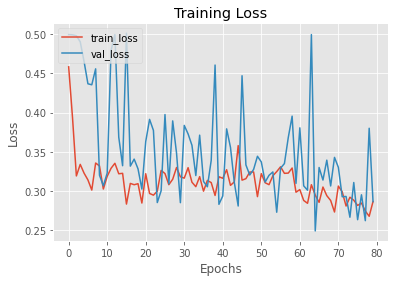

In [ ]:
#plot training history
plot_training(history, data_path) 
#The ideal number of iterations is found when the validation loss start to grow, 
#thus the number of epochs should not be increased more. 
#The EarlyStopping helps in this.

In [ ]:
image_query = process_images(query_paths)
image_gallery = process_images(gallery_paths)

Make pairs and return the distances between images, applying the model to enstablish similarity.

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#Randomly generates 10 pairs, 
#each one composed of a random image taken from the query and a random image from the gallery.
pairs = []
np.random.seed(1)
for i in range(0, 10):
  lst = []
  rand_gallery = np.random.choice(gallery_paths)
  rand_query = np.random.choice(query_paths)
  lst.append(rand_gallery)
  lst.append(rand_query)
  pairs.append(lst)

In [ ]:
model = make_or_restore_model()

0.32904154


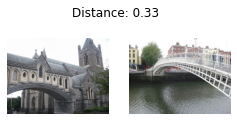

0.7923087


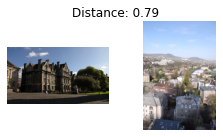

0.16425587


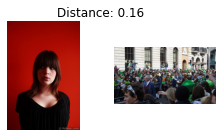

0.38543504


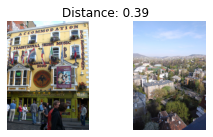

0.061378106


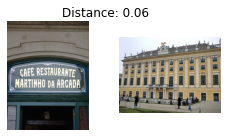

0.4966152


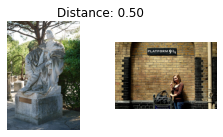

0.58309954


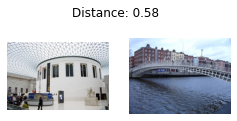

0.57786787


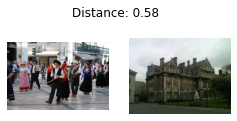

0.608894


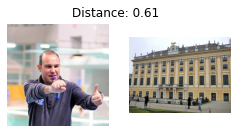

0.5504032


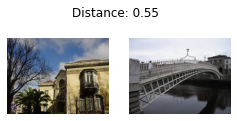

In [ ]:
for lst_of_img in pairs:
  #pre-process the pairs
  processed_lst_of_img = process_images(lst_of_img) 

  #make predictions
  preds = model.predict([processed_lst_of_img[0], processed_lst_of_img[1]])
  dist = preds[0][0]
  print(dist)

  #plot the pairs with their distances
  fig = plt.figure(figsize=(4, 2))
  plt.suptitle("Distance: {:.2f}".format(dist))
  ax = fig.add_subplot(1, 2, 1)
  img = cv2.imread(lst_of_img[0]) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis("off")
  ax = fig.add_subplot(1, 2, 2)
  img = cv2.imread(lst_of_img[1]) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis("off")
  plt.show()


Apply the model so that the top 10 query-gallery matches are returned.



In [ ]:
def match_img(one_image_query):
  image_gallery = process_images(gallery_paths)
  distance_list = []
  for g_img in image_gallery:
    preds = model.predict([one_image_query, g_img])
    dist = preds[0][0]
    distance_list.append(dist)
  top10 = np.argsort(distance_list)[:10]  #top 10 results 
  scores = [(distance_list[a], gallery_paths[a]) for a in top10] #rank the results
  return (top10, scores)

In [ ]:
#Process query images and take a processed image to test the model on.
image_query = process_images(query_paths)

In [ ]:
match_img(image_query[1]) 

(array([ 11, 230, 366, 458, 228, 498, 247, 425, 411, 243]),
 [(0.0039381743,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/14/ec50k_00140005.jpg'),
  (0.0062980265,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3493783009_54aec7435f.jpg'),
  (0.007970229,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3581448651_d6cbeebea2.jpg'),
  (0.008141337,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/7/ec50k_00070008.jpg'),
  (0.013872624,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3410742505_8a7b7e2e6a.jpg'),
  (0.015068162,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/18/ec50k_00180012.jpg'),
  (0.018734736,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3580772257_a3a261001d.jpg'),
  (0.019896137,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/2888982165_18

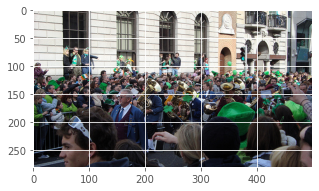

In [ ]:
#query image chosen: 
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize = (5,5))
img = cv2.imread(query_paths[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
#classe 18

With other images:

In [ ]:
match_img(image_query[15])

(array([533, 398, 442, 475,  49,   4, 333, 340, 328, 471]),
 [(0.00031622776,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/2/ec50k_00020008.jpg'),
  (0.00031622776,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3109437893_96bfc1b796.jpg'),
  (0.00031622776,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/2961558817_80b6b0dfdd.jpg'),
  (0.00031622776,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/8/ec50k_00080020.jpg'),
  (0.00035758075,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/11/ec50k_00110015.jpg'),
  (0.00044312223,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/14/ec50k_00140007.jpg'),
  (0.00060503965,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3588005991_048e719152.jpg'),
  (0.0006916939,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/2521909845_679c0

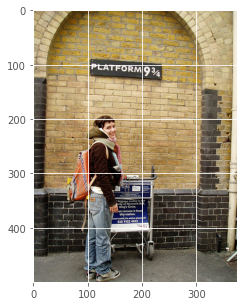

In [ ]:
#query image chosen: 
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize = (5,5))
img = cv2.imread(query_paths[15])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
#classe 11

In [ ]:
match_img(image_query[10])

(array([297, 231, 334, 355, 140, 101, 240,  89, 330, 513]),
 [(0.004452892,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3117006010_30b528c958.jpg'),
  (0.004857872,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3593752270_9e5a41a5cb.jpg'),
  (0.006624048,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3344593856_93dcd65473.jpg'),
  (0.0077590263,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3551923608_1ac2843775.jpg'),
  (0.008183833,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3570737432_19b26cd7eb.jpg'),
  (0.0119564505,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3473601003_5319ec5218.jpg'),
  (0.014029551,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery/distractor/3409333569_891afca142.jpg'),
  (0.018443868,
   'drive/MyDrive/AML_Challenge/dataset_senza_a

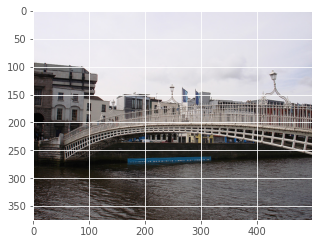

In [ ]:
#query image chosen: 
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize = (5,5))
img = cv2.imread(query_paths[10])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
#classe 14

**CHALLENGE DAY:**

Testing the model:

In [20]:
test_path= os.path.join(data_path, "test")

gallery_path = os.path.join(test_path, 'gallery')
query_path = os.path.join(test_path, 'query')

def imag_load(path) : 
  temp_images = os.listdir(path)
  lista = []
  for i in temp_images:
    img_tmp = os.path.join(path, i)
    lista.append(img_tmp)
  return lista

gallery = imag_load(gallery_path)
query = imag_load(query_path)

In [21]:
image_gallery = process_images(gallery)

In [23]:
image_query = process_images(query)

In [24]:
def match_img(one_image_query):
  distance_list = []
  for g_img in image_gallery:
    preds = model.predict([one_image_query, g_img])
    dist = preds[0][0]
    distance_list.append(dist)
  top10 = np.argsort(distance_list)[:10]  #top 10 results 
  scores = [(distance_list[a], gallery[a]) for a in top10] #rank the results
  return scores

In [26]:
from pprint import pprint
results = {}
for img in query: 
  results[os.path.basename(img)] = []
for i, feat in enumerate(image_query) : 
  scores = match_img(feat)
  results[os.path.basename(query[i])].extend([os.path.basename(sc[1]) for sc in scores])
pprint(results)

{'3fpri33.jpg': ['w8mwx3t.jpg',
                 'o2yp6a5.jpg',
                 '08ywkog.jpg',
                 '84iump4.jpg',
                 'xmzx0qv.jpg',
                 'hnctsz5.jpg',
                 'kajq9xb.jpg',
                 '39gsyrg.jpg',
                 'xlljbla.jpg',
                 '30gyw3v.jpg'],
 '4uufzmh.jpg': ['h5ynz5j.jpg',
                 '99waaeg.jpg',
                 'kx0hd4t.jpg',
                 '4i7uy3a.jpg',
                 '7owpgy9.jpg',
                 'psc4i5p.jpg',
                 'z6o0m39.jpg',
                 'lv2zrrb.jpg',
                 'wyfwt3h.jpg',
                 '92q49gl.jpg'],
 '5qcsiay.jpg': ['5fk0aiw.jpg',
                 'vdygdcy.jpg',
                 '5ke31ly.jpg',
                 'mq275v4.jpg',
                 'yxwrcpa.jpg',
                 'qniuwac.jpg',
                 'ehevs8e.jpg',
                 'vpfxrth.jpg',
                 '14uoy8b.jpg',
                 '0rykugm.jpg'],
 '8d6bnrk.jpg': ['14uoy8b.jpg',
     

In [27]:
import requests
import json


url = "http://ec2-18-191-24-254.us-east-2.compute.amazonaws.com/test/"


In [28]:
mydata = dict()
mydata['groupname'] = "lesdesesperadas"


res = results
mydata["images"] = res
pprint(mydata)

{'groupname': 'lesdesesperadas',
 'images': {'3fpri33.jpg': ['w8mwx3t.jpg',
                            'o2yp6a5.jpg',
                            '08ywkog.jpg',
                            '84iump4.jpg',
                            'xmzx0qv.jpg',
                            'hnctsz5.jpg',
                            'kajq9xb.jpg',
                            '39gsyrg.jpg',
                            'xlljbla.jpg',
                            '30gyw3v.jpg'],
            '4uufzmh.jpg': ['h5ynz5j.jpg',
                            '99waaeg.jpg',
                            'kx0hd4t.jpg',
                            '4i7uy3a.jpg',
                            '7owpgy9.jpg',
                            'psc4i5p.jpg',
                            'z6o0m39.jpg',
                            'lv2zrrb.jpg',
                            'wyfwt3h.jpg',
                            '92q49gl.jpg'],
            '5qcsiay.jpg': ['5fk0aiw.jpg',
                            'vdygdcy.jpg',
                   

In [29]:
def submit(results, url):
    res = json.dumps(results)
    response = requests.post(url, res)
    result = json.loads(response.text)
    print(f"accuracy is {result['results']}")

submit(mydata, url)

accuracy is {'top1': 0.0, 'top3': 0.0, 'top10': 0.0}
